In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import dowhy
from dowhy.do_why import CausalModel
import dowhy.datasets
import numpy as np
import networkx as nx
import xmltodict

import pandas as pd
from datetime import datetime
from tqdm import tqdm, tqdm_notebook

## Step 1 - Simulate Data from BIMP

1. BIMP - http://bimp.cs.ut.ee/simulator
2. Save the MXML file generated

## Step 2 - Aggregate the MXML Data
Process variable/ inference variable, inference variable 

In [2]:
# change this as required
mxml_filename = '../data/logs/A.1.simulation_logs.mxml'
csv_filename = '../data/aggregates/A.1.csv'
groupby_time_frequency = 'H'

In [20]:
# calculates aggregates
df = pd.DataFrame(columns=['case_id', 'activity', 'resource', 'complete_timestamp'])

with open(mxml_filename) as f:
    doc = xmltodict.parse(f.read())

for instance in tqdm(doc['WorkflowLog']['Process']['ProcessInstance']):
    case_id = instance['@id']
    resource = None
    iterator = instance['AuditTrailEntry']
    iterator.sort(key=lambda x: x['Timestamp'])
    for entry in iterator:
        if entry['EventType'] == 'assign':
            try:
                resource = entry['Originator']
            except KeyError:
                resource = None
            continue
        df = df.append({
            'case_id': case_id,
            'activity': entry['WorkflowModelElement'],
            'resource': resource,
            'complete_timestamp': entry['Timestamp']
        }, ignore_index=True)

df.head()

100%|██████████| 10000/10000 [06:55<00:00, 24.06it/s]


,case_id,activity,resource,complete_timestamp
0,2182,Start Event,None,2019-06-25T14:36:29.522+00:00
1,2182,Task 1,Resource 1,2019-06-26T14:43:12.551+00:00
2,2182,Task 2,Resource 2,2019-06-27T09:22:36.996+00:00
3,2182,Task 3,Resource 3,2019-07-04T10:07:11.317+00:00
4,2182,End Event,None,2019-07-04T10:07:11.317+00:00


In [21]:
df['completion_datetime'] = pd.to_datetime(df.complete_timestamp, format='%Y-%m-%dT%H:%M:%S.%f+00:00')
df.drop(columns='complete_timestamp', inplace=True)
df.fillna('None', inplace=True)
    
all_columns = ['timestamp'] + list(df['resource'].unique()) + list(df['activity'].unique())
data_aggregate = pd.DataFrame(columns=all_columns)

grouped = df.groupby(pd.Grouper(key='completion_datetime', freq=groupby_time_frequency))
for name1, group1 in tqdm(grouped):
    temp_row = {key: 0 for key in all_columns}
    temp_row['timestamp'] = name1
    for name2, group2 in group1.groupby(['activity', 'resource']):
        count = len(group2['case_id'].unique())
        try:
            temp_row[name2[0]] += count
        except KeyError:
            pass
        try:
            temp_row[name2[1]] += count
        except KeyError:
            pass
    data_aggregate = data_aggregate.append(temp_row, ignore_index=True)

data_aggregate['hour'] = data_aggregate['timestamp'].apply(lambda x: x.hour)
data_aggregate.drop(columns=['timestamp', 'None'], inplace=True)
data_aggregate.head()

100%|██████████| 14353/14353 [01:24<00:00, 169.06it/s]


,Resource 1,Resource 2,Resource 3,Start Event,Task 1,Task 2,Task 3,End Event,hour
0,3,1,1,3,3,1,1,1,9
1,1,2,1,5,1,2,1,1,10
2,2,2,3,4,2,2,3,3,11
3,4,2,1,2,4,2,1,1,12
4,3,4,3,2,3,4,3,3,13


In [22]:
# write to CSV file
data_aggregate.to_csv(csv_filename, index=False)

## Step 3 - Perform Structure Learning
This step is done in R.

```
library(bnlearn)

# edit input CSV filename
csv_filename <- "~/Documents/dev/bpm-causal/ipynb/new_aggregate.csv";

# read data
data <- read.csv(csv_filename);
# data[] <- lapply(data, as.factor)
data[] <- lapply(data, as.numeric)

# define blacklisted edges
partial_order = list(
  c("Start.Event"), 
  c("Task.1", "Resource.1"), 
  c("Task.2", "Resource.2"), 
  c("Task.3"), 
  c("End.Event"))
blacklist_edges <- tiers2blacklist(partial_order)

# add additional blacklisted edges
blacklist_edges <- rbind(blacklist_edges, c("Resource.1", "Resource.2"))
blacklist_edges <- rbind(blacklist_edges, c("Start.Event", "Resource.2"))

causal_model <- tabu(data, blacklist = blacklist_edges)

plot(causal_model)
print(causal_model["arcs"])
```

Copy paste the output.

Blacklist all edges from task to resource

In [59]:
# edit this according to R output
edges_list_str = """
 [1,] "Resource.1"  "Task.1"     
 [2,] "Resource.1"  "Task.2"     
 [3,] "Resource.2"  "Task.2"     
 [4,] "Resource.2"  "Task.3"     
 [5,] "Resource.3"  "Task.3"     
 [6,] "Start.Event" "Task.1"     
 [7,] "Start.Event" "Task.2"     
 [8,] "Start.Event" "End.Event"  
 [9,] "Task.1"      "Task.2"     
[10,] "Task.2"      "Task.3"     
[11,] "Task.3"      "End.Event"  
[12,] "hour"        "Start.Event"      """

In [114]:
edges_list = []
for line in edges_list_str.split("\n"):
    line = line.strip().split(' ')
    line = list(filter(lambda x: len(x) > 0, line))
    if len(line) < 3:
        continue
    edges_list.append((line[1][1:-1], line[2][1:-1]))
edges_list = [(a.replace('.', ' '), b.replace('.', ' ')) for (a, b) in edges_list]
edges_list

[('Resource 1', 'Task 1'),
 ('Resource 1', 'Task 2'),
 ('Resource 2', 'Task 2'),
 ('Resource 2', 'Task 3'),
 ('Resource 3', 'Task 3'),
 ('Start Event', 'Task 1'),
 ('Start Event', 'Task 2'),
 ('Start Event', 'End Event'),
 ('Task 1', 'Task 2'),
 ('Task 2', 'Task 3'),
 ('Task 3', 'End Event'),
 ('hour', 'Start Event')]

## Step 4 - Use `dowhy` to perform inference

In [128]:
edges_list = [('Start Event', "Task 1"),
              ('Task 1', "Task 2"),
              ('Task 2', "Task 3"),
              ('Task 3', "End Event"),
              ('Resource 1', 'Task 1'),
              ('Resource 2', 'Task 2'),
              ('Resource 3', 'Task 3')]

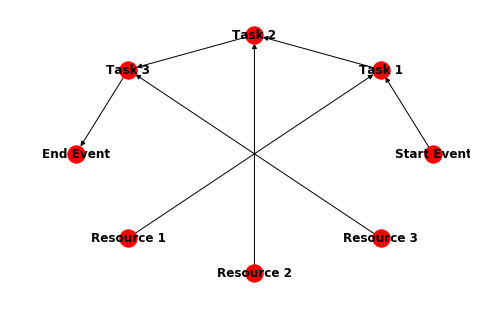

In [129]:
lucas_graph = nx.DiGraph()
lucas_graph.add_edges_from(edges_list)

nx.draw_circular(lucas_graph, with_labels=True, font_weight='bold')

In [155]:
new_data_aggregate = data_aggregate[data_aggregate['hour'] > 8]
new_data_aggregate = new_data_aggregate[data_aggregate['hour'] <17]
new_data_aggregate.head()

/Users/tanmayee/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Resource 1,Resource 2,Resource 3,Start Event,Task 1,Task 2,Task 3,End Event,hour
0,3,1,1,3,3,1,1,1,9
1,1,2,1,5,1,2,1,1,10
2,2,2,3,4,2,2,3,3,11
3,4,2,1,2,4,2,1,1,12
4,3,4,3,2,3,4,3,3,13


Model to find the causal effect of treatment Resource 1 on outcome Task 2


/Users/tanmayee/anaconda/envs/py36/lib/python3.6/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: Could not load "/Users/tanmayee/anaconda/envs/py36/lib/graphviz/libgvplugin_pango.6.dylib" - file not found

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


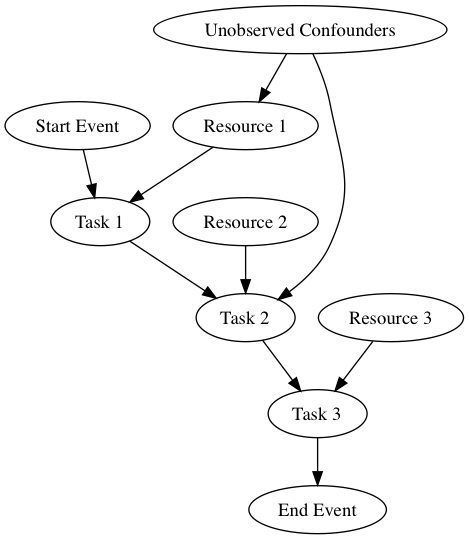

In [152]:
lucas_graph_str = ''.join(list(nx.generate_gml(lucas_graph)))

lucas_model = CausalModel(
                data = new_data_aggregate,
                treatment="Resource 1",
                outcome="Task 2",
                graph=lucas_graph_str
                )
lucas_model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [153]:
# Identify causal effect and return target estimands
identified_estimand = lucas_model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'U'}


{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                           
───────────(Expectation(Task 2|))
dResource 1                      
Estimand assumption 1, Unconfoundedness: If U→Resource 1 and U→Task 2 then P(Task 2|Resource 1,,U) = P(Task 2|Resource 1,)
### Estimand : 2
Estimand name: iv
No such variable found!



In [154]:
# Estimate the target estimand using a statistical method.
estimate = lucas_model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Task 2~Resource 1


LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                           
───────────(Expectation(Task 2|))
dResource 1                      
Estimand assumption 1, Unconfoundedness: If U→Resource 1 and U→Task 2 then P(Task 2|Resource 1,,U) = P(Task 2|Resource 1,)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Task 2~Resource 1
## Estimate
Value: 0.6684591438752262

Causal Estimate is 0.6684591438752262


In [140]:
causal_estimate_strat = lucas_model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Task 2~Resource 1


PropensityScoreStratificationEstimator


ValueError: Found array with 0 feature(s) (shape=(14353, 0)) while a minimum of 1 is required.

In [141]:
causal_estimate_match = lucas_model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: Task 2~Resource 1


PropensityScoreMatchingEstimator


ValueError: Found array with 0 feature(s) (shape=(14353, 0)) while a minimum of 1 is required.

In [142]:
causal_estimate_ipw = lucas_model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting")
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: Task 2~Resource 1


PropensityScoreWeightingEstimator


ValueError: Found array with 0 feature(s) (shape=(14353, 0)) while a minimum of 1 is required.